In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Dataset Information

### behaviors.tsv
The behaviors.tsv file contains the impression logs and users' news click hostories. It has 5 columns divided by the tab symbol:
* Impression ID: The ID of an impression.
* User ID: The anonymous ID of a user.
* Time: The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
* History: The news click history (ID list of clicked news) of this user before this impression. The clicked news articles are ordered by time.
* Impressions: List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click). The orders of news in a impressions have been shuffled.

### news.tsv
The docs.tsv file contains the detailed information of news articles involved in the behaviors.tsv file. It has 7 columns, which are divided by the tab symbol:

* News ID
* Category
* SubCategory
* Title
* Abstract
* URL (We are sorry that the URLs have expired now)
* Title Entities (entities contained in the title of this news)
* Abstract Entities (entites contained in the abstract of this news)

# 1. Data Acquisition

In [39]:
behaviors_path = "data/behaviors.tsv"
news_path = "data/news.tsv"

df_behaviors = pd.read_csv(behaviors_path, sep='\t', header=None, names=[
    "ImpressionID", "UserID", "Time", "History", "Impressions"
])

df_news = pd.read_csv(news_path, sep='\t', header=None, names=[
    "NewsID", "Category", "SubCategory", "Title", "Abstract", "URL", "TitleEntities", "AbstractEntities"
])


In [23]:
# df_behaviors = df_behaviors[0:50000]

# 2. Data Understanding and Exploration 

## 2.1 Behaviors dataframe exploration

#### 2.1.1 Shape

In [40]:
print(f"Number of rows: {df_behaviors.shape[0]}")
print(f"Number of columns: {df_behaviors.shape[1]}")

Number of rows: 2232748
Number of columns: 5


#### 2.1.2 Null values

In [41]:
df_behaviors.isna().sum()

ImpressionID        0
UserID              0
Time                0
History         46065
Impressions         0
dtype: int64

#### 2.1.3 Distribution of Number of Impressions per Row)

In [42]:
df_behaviors['Num_Impressions'] = df_behaviors['Impressions'].str.split().apply(len)
df_behaviors['Num_Impressions'].describe()

count    2.232748e+06
mean     3.740116e+01
std      3.874256e+01
min      2.000000e+00
25%      1.000000e+01
50%      2.500000e+01
75%      5.100000e+01
max      3.000000e+02
Name: Num_Impressions, dtype: float64

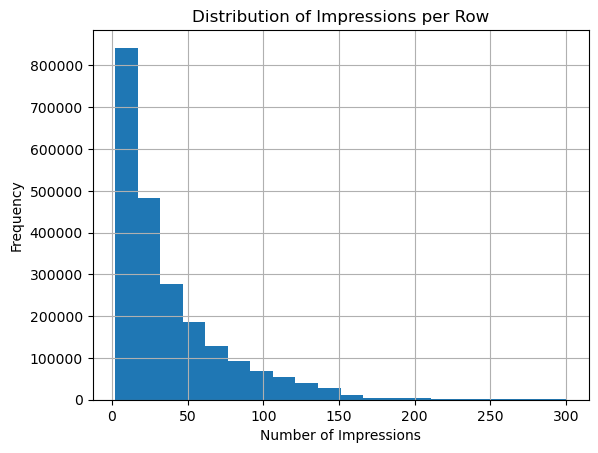

In [43]:
df_behaviors['Num_Impressions'].hist(bins=20)
plt.title("Distribution of Impressions per Row")
plt.xlabel("Number of Impressions")
plt.ylabel("Frequency")
plt.show()

<b>Insights:</b>

* The mean number of impressions per session is ~37, which is consistent with the subset.

* The distribution is heavily right-skewed, with a high concentration of sessions having fewer than 50 impressions.

* The long tail extends to 300 impressions per session — indicating very active users or possibly bots.

* Around 25% of sessions have fewer than 10 impressions — highlighting quick or shallow user visits.

<b>Why This Matters:</b>

* Understanding the number of impressions per session:

* Helps in tuning negative sampling (non-clicked items) per session.

* Informs whether to use a fixed-size or variable-length input for models like NRMS or DIN.

* Reveals user engagement depth — short sessions might require simpler, fast-response models.

#### 2.1.4 Click vs Non-click Ratio

In [44]:
clicks = 0
total = 0

for imp in df_behaviors['Impressions']:
    for item in imp.split():
        if "-" in item:
            _, label = item.split("-")
            clicks += int(label)
            total += 1

ctr = clicks / total
print(f"Total impressions: {total}")
print(f"Total clicks: {clicks}")
print(f"Click-Through Rate (CTR): {ctr:.4f}")

Total impressions: 83507374
Total clicks: 3383656
Click-Through Rate (CTR): 0.0405


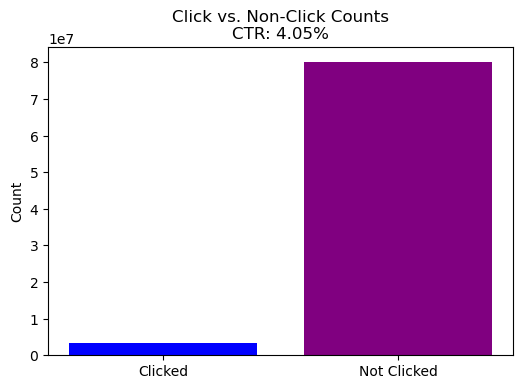

In [45]:
clicks = 0
total = 0

for imp in df_behaviors['Impressions']:
    for item in imp.split():
        if "-" in item:
            _, label = item.split("-")
            clicks += int(label)
            total += 1

non_clicks = total - clicks
ctr = clicks / total

plt.figure(figsize=(6, 4))
plt.bar(['Clicked', 'Not Clicked'], [clicks, non_clicks], color=['blue', 'purple'])
plt.title(f"Click vs. Non-Click Counts\nCTR: {ctr:.2%}")
plt.ylabel("Count")
plt.show()

<b>Insights:</b>
* The dataset is highly imbalanced, with only ~4% of impressions resulting in a click.

* The vast majority of recommendations are ignored by users, which is common in real-world recommendation systems (users don’t click most items).

* The click data provides positive feedback, but the overwhelming majority of impressions are implicit negatives.

<b>Why This Matters:</b>
* The 4.05% CTR becomes your baseline to beat with smarter models.

* The data is highly imbalanced, so you’ll need techniques like negative sampling or class weighting.

* Ranking metrics (e.g., Hit@K, MRR) are more appropriate than raw accuracy.

####  2.1.5 Distribution of User History Length

In [46]:
df_behaviors['History_Length'] = df_behaviors['History'].fillna('').str.split().apply(len)
df_behaviors['History_Length'].describe()

count    2.232748e+06
mean     3.297724e+01
std      4.087336e+01
min      0.000000e+00
25%      8.000000e+00
50%      1.900000e+01
75%      4.200000e+01
max      8.010000e+02
Name: History_Length, dtype: float64

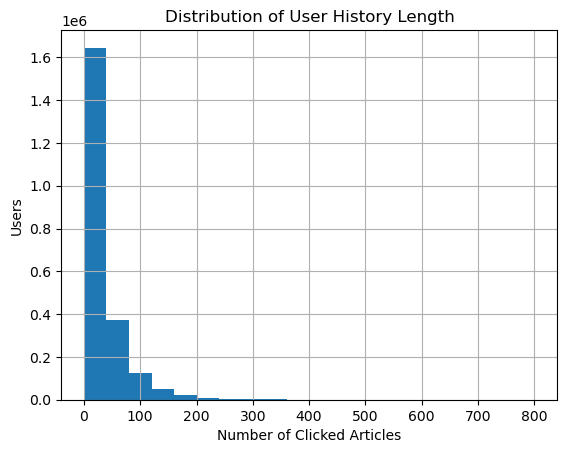

In [47]:
df_behaviors['History_Length'].hist(bins=20)
plt.title("Distribution of User History Length")
plt.xlabel("Number of Clicked Articles")
plt.ylabel("Users")
plt.show()

<b>Insights:</b>
* Most users have clicked on fewer than 50 articles.

* Around 25% of sessions have a history length of ≤ 8, making them borderline cold-start.

* A few users have hundreds of past clicks, indicating high engagement.

<b>Why This Matters:</b>
* Helps decide the input length for user models (e.g., max history = 50).

* Sessions with short history may need content-based fallback.

* Users with long history allow for richer personalization.

#### 2.1.6 Time Range and Daily Coverage

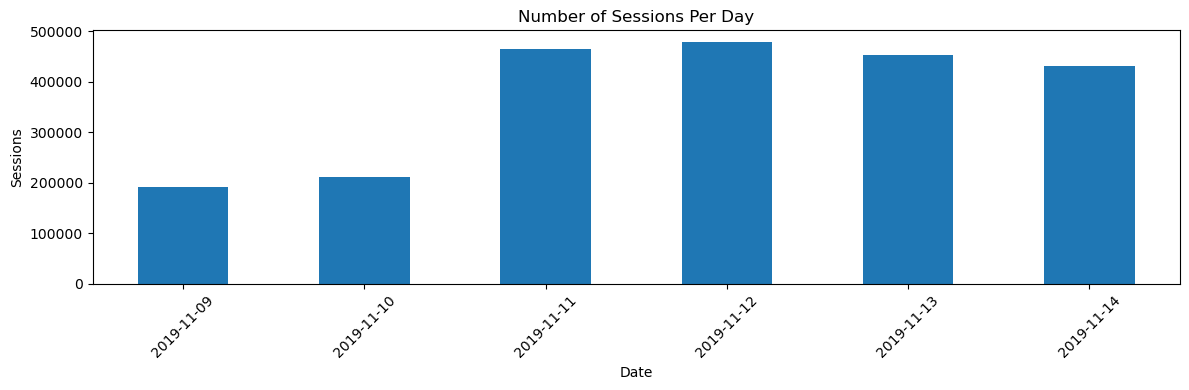

In [48]:
df_behaviors['Time'] = pd.to_datetime(df_behaviors['Time'])
df_behaviors['Date'] = df_behaviors['Time'].dt.date

df_behaviors['Date'].value_counts().sort_index().plot(kind='bar', figsize=(12, 4))
plt.title("Number of Sessions Per Day")
plt.xlabel("Date")
plt.ylabel("Sessions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<b>Insights:</b>
* There is a significant increase in user activity starting from 2019-11-11, peaking on 2019-11-12.

* The earlier days (Nov 9–10) had fewer sessions, possibly due to limited user acquisition or testing phase.

* Overall, the system shows a stable high-load pattern during the last 4 days.

<b>Why This Matters:<b/>
* Helps assess whether your data is temporally biased or imbalanced.

* Ensures models aren't overfitting to one active day.

* Useful for temporal split in training/testing if building a time-aware recommender.

## 2.2 News dataframe exploration

### 2.2.1 Dataset Size and Basic Structure

In [50]:
print(f"Number of articles: {df_news.shape[0]}")
print("Columns:", df_news.columns.tolist())
df_news.head()

Number of articles: 101527
Columns: ['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities']


,NewsID,Category,SubCategory,Title,Abstract,URL,TitleEntities,AbstractEntities
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ..."
2,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
3,N86255,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."


### 2.2.2 Missing Values

In [51]:
df_news.isna().sum()

NewsID                 0
Category               0
SubCategory            0
Title                  0
Abstract            5415
URL                    0
TitleEntities          3
AbstractEntities       6
dtype: int64

### 2.2.3 Unique News Count

In [52]:
df_news['NewsID'].nunique()

101527

### 2.2.4 Title and Abstract Length Distribution

In [53]:
df_news['TitleLength'] = df_news['Title'].fillna('').str.split().apply(len)
df_news['AbstractLength'] = df_news['Abstract'].fillna('').str.split().apply(len)

df_news[['TitleLength', 'AbstractLength']].describe()

,TitleLength,AbstractLength
count,101527.000000,101527.000000
mean,10.665518,36.240064
std,3.263087,26.897624
min,1.000000,0.000000
25%,8.000000,15.000000
50%,10.000000,25.000000
75%,13.000000,66.000000
max,95.000000,474.000000


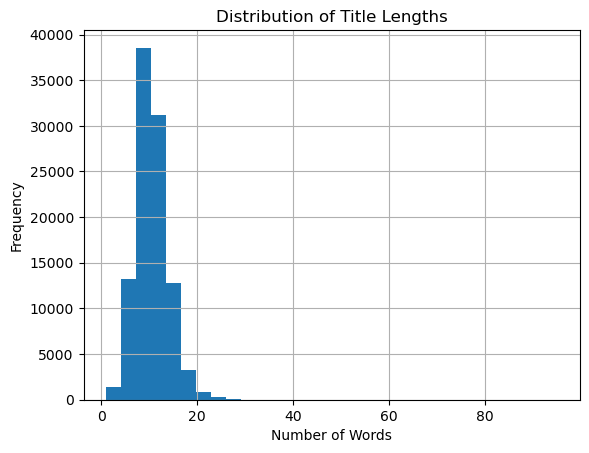

In [54]:
df_news['TitleLength'].hist(bins=30)
plt.title("Distribution of Title Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

<b>Insights:</b>
* Most titles range between 8–13 words, making them ideal for short-text models or BERT truncation.

* Abstracts show high variance — while many are short, some go beyond 400 words.

* Some articles have empty abstracts, which may need fallback handling.

<b>Why This Matters:</b>
* Helps choose the max sequence length for tokenization and padding (e.g., 15–20 for titles, 100–150 for abstracts).

* Titles can be used for fast models (TF-IDF, LightGBM), while abstracts offer richer signals for deep models.

### 2.2.5 Category and Subcategory Distribution

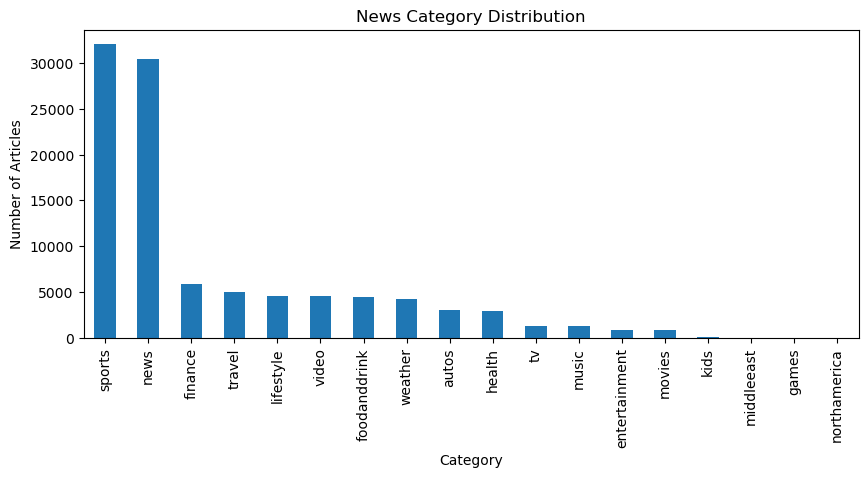

In [55]:
df_news['Category'].value_counts().plot(kind='bar', figsize=(10, 4), title='News Category Distribution')
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.show()

<b> Insights </b>
* The dataset is dominated by "sports" and "news", which together account for over half of all articles.

* Other prominent categories include finance, travel, lifestyle, and weather.

* Some categories like kids, games, and middleeast are underrepresented.

<b> Why This Matters:</b>
* Category imbalance can bias models toward overrepresented topics.

* Underserved categories may require category-aware sampling or upsampling to avoid underperformance.

* Enables building category-specific recommenders or multi-task classification models.

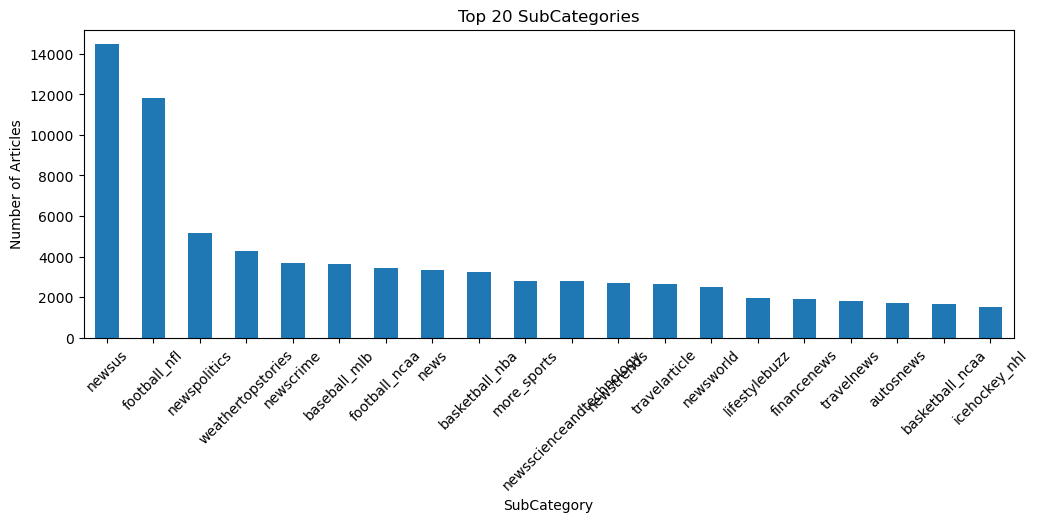

In [56]:
df_news['SubCategory'].value_counts().head(20).plot(kind='bar', figsize=(12, 4), title='Top 20 SubCategories')
plt.xlabel("SubCategory")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()

<b>Insights:</b>
* newsus, football_nfl, and newspolitics dominate the subcategory space.

* Sports-related subcategories like football_nfl, baseball_mlb, basketball_nba, and icehockey_nhl are heavily represented.

* There's good diversity across news, sports, crime, weather, and finance topics.

<b>Why This Matters:</b>
* Subcategories offer richer content-based signals for fine-grained recommendation.

* They enable hierarchical modeling (e.g., predict category first, then subcategory).

* Popular subcategories may bias general-purpose models, so diversity-aware sampling can be useful.

### 2.2.6 Top Named Entities in Titles

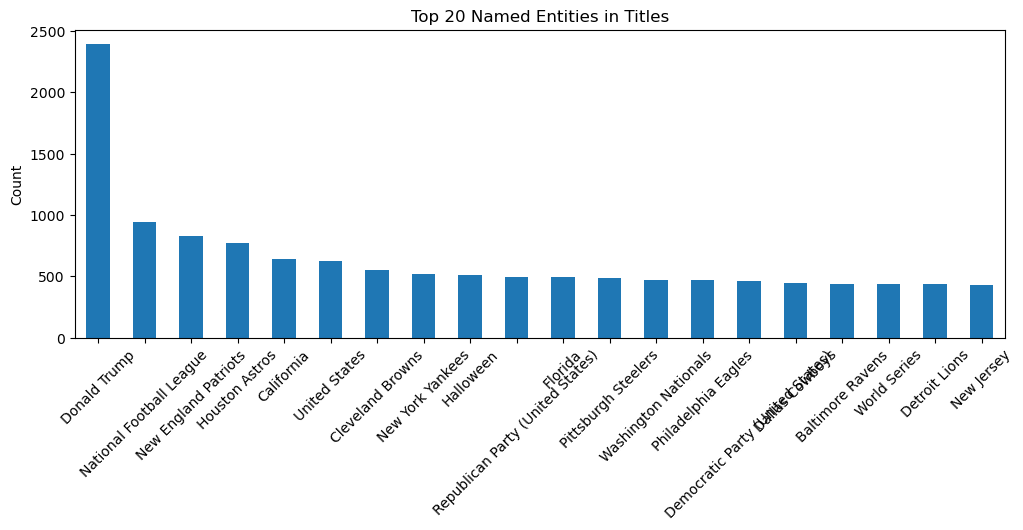

In [58]:
import ast
from collections import Counter

def extract_entity_labels(entities_str):
    try:
        entities = ast.literal_eval(entities_str)
        return [e['Label'] for e in entities]
    except:
        return []

df_news['EntityLabels'] = df_news['TitleEntities'].apply(extract_entity_labels)

all_labels = [label for sublist in df_news['EntityLabels'] for label in sublist]
entity_counts = Counter(all_labels)
top_entities = dict(entity_counts.most_common(20))

pd.Series(top_entities).plot(kind='bar', figsize=(12, 4), title="Top 20 Named Entities in Titles")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

<b>Insights:</b>
* Donald Trump appears far more frequently than any other entity — indicating political topics were highly prevalent.

* Many entities belong to sports organizations and U.S. political groups, such as:
    * National Football League, New England Patriots, Democratic / Republican Party

* Entities like California, Florida, and New York Yankees show strong geographic diversity.

<b>Why This Matters:</b>
* Entities offer semantic signals to improve user profiling and content similarity.

* Enables entity-aware recommenders that go beyond word matching (e.g., Wikidata-enhanced retrieval).

* High-frequency entities help in creating clustered topic embeddings and addressing cold-start problems.



In [27]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101527 entries, 0 to 101526
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   NewsID            101527 non-null  object
 1   Category          101527 non-null  object
 2   SubCategory       101527 non-null  object
 3   Title             101527 non-null  object
 4   Abstract          96112 non-null   object
 5   URL               101527 non-null  object
 6   TitleEntities     101524 non-null  object
 7   AbstractEntities  101521 non-null  object
dtypes: object(8)
memory usage: 6.2+ MB


# 3. Feature Engineering

## Problem with `Impressions` and `History` Columns and Importance of Feature Engineering

### Problem Description

The `behaviors.tsv` file contains user interaction data with two key columns that need transformation:

#### `Impressions` Column:
Each row contains multiple news article interactions for a session in the format:fo

N129416-0 N26703-1 N120089-1 ...

Each item represents:
- `NewsID`: Unique news article ID (e.g., `N129416`)
- `Click`: Binary flag (`1` = clicked, `0` = not clicked)

#### `History` Column:
Represents articles read by the user **before the current session**, in the format:

N8668 N39081 N65259 ...

Each value is:
- A `NewsID` the user clicked on in previous sessions

---

### Problems in Raw Format

- Both columns store **multiple values in a single field**, making them unsuitable for analysis or modeling
- There's **no row-level mapping** for individual user-article interactions
- In `History`, each user's past activity is not associated with specific impressions unless explicitly joined
- Prevents direct merging with `news.tsv` for metadata (e.g., title, category)

---

### Why Feature Engineering is Needed

To solve these issues, we transform the data into structured formats:

#### Transformed `Impressions` Format:

| UserID | ImpressionID | Time       | Impression-news-id | Click |
|--------|---------------|------------|---------------------|--------|
| U123   | 1             | 2023-07-01 | N129416             | 0      |
| U123   | 1             | 2023-07-01 | N26703              | 1      |

#### Transformed `History` Format:

| UserID | ImpressionID | Time       | History-news-id |
|--------|---------------|------------|------------------|
| U123   | 1             | 2023-07-01 | N8668            |
| U123   | 1             | 2023-07-01 | N39081           |

Or optionally, a **merged view** with full history as a list:

| UserID | ImpressionID | Time       | Impression-news-id | Click | History                            |
|--------|---------------|------------|---------------------|--------|-------------------------------------|
| U123   | 1             | 2023-07-01 | N129416             | 0      | ['N8668', 'N39081', 'N65259']       |

---

### Benefits of Feature Engineering

1. **Supervised Learning Ready**  
   - One row per impression, enabling binary classification (click vs no-click)

2. **Merge with News Metadata**  
   - Easily join with `news.tsv` for title, category, abstract, etc.

3. **Supports Multiple ML Models**  
   - Collaborative filtering (user-item matrix)  
   - Content-based filtering (textual similarity)  
   - Hybrid and deep models (e.g., NAML, NRMS)

4. **User Behavior & Sequence Modeling**  
   - History can be fed into RNN/Transformer models for sequence-based predictions  
   - Enables time-aware and context-aware recommendations

5. **Interpretability & Analysis**  
   - Analyze user trends, CTR by category or time  
   - Explain recommendations using historical behavior

---


In [3]:
import csv

output_file = "parsed_behaviors.csv"

# Create output CSV and write header
with open(output_file, mode='w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=[
        "ImpressionID", "UserID", "Time", "Impression-news-id", "Click", "History"
    ])
    writer.writeheader()

    for _, row in df_behaviors.iterrows():
        impressions = row["Impressions"].split()
        history = row["History"].split() if pd.notna(row["History"]) else []

        for imp in impressions:
            try:
                news_id, click = imp.split("-")
                writer.writerow({
                    "ImpressionID": row["ImpressionID"],
                    "UserID": row["UserID"],
                    "Time": row["Time"],
                    "Impression-news-id": news_id,
                    "Click": int(click),
                    "History": " ".join(history)  # as string
                })
            except ValueError:
                continue

In [5]:
behaviors_path = "parsed_behaviors.csv"
df_behaviors = pd.read_csv(behaviors_path)

In [12]:
# For initial phase working with only 50k records.

In [13]:
df_behaviors = df_behaviors[0:50000]

In [14]:
df_behaviors.shape

(50000, 6)

In [17]:
df_behaviors.head()

,ImpressionID,UserID,Time,Impression-news-id,Click,History
0,1,U87243,11/10/2019 11:30:54 AM,N78206,0,N8668 N39081 N65259 N79529 N73408 N43615 N2937...
1,1,U87243,11/10/2019 11:30:54 AM,N26368,0,N8668 N39081 N65259 N79529 N73408 N43615 N2937...
2,1,U87243,11/10/2019 11:30:54 AM,N7578,0,N8668 N39081 N65259 N79529 N73408 N43615 N2937...
3,1,U87243,11/10/2019 11:30:54 AM,N58592,0,N8668 N39081 N65259 N79529 N73408 N43615 N2937...
4,1,U87243,11/10/2019 11:30:54 AM,N19858,0,N8668 N39081 N65259 N79529 N73408 N43615 N2937...


In [16]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101527 entries, 0 to 101526
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   NewsID            101527 non-null  object
 1   Category          101527 non-null  object
 2   SubCategory       101527 non-null  object
 3   Title             101527 non-null  object
 4   Abstract          96112 non-null   object
 5   URL               101527 non-null  object
 6   TitleEntities     101524 non-null  object
 7   AbstractEntities  101521 non-null  object
dtypes: object(8)
memory usage: 6.2+ MB


In [20]:
df_news['TitleEntities'][0]

'[{"Label": "Prince Philip, Duke of Edinburgh", "Type": "P", "WikidataId": "Q80976", "Confidence": 1.0, "OccurrenceOffsets": [48], "SurfaceForms": ["Prince Philip"]}, {"Label": "Charles, Prince of Wales", "Type": "P", "WikidataId": "Q43274", "Confidence": 1.0, "OccurrenceOffsets": [28], "SurfaceForms": ["Prince Charles"]}, {"Label": "Elizabeth II", "Type": "P", "WikidataId": "Q9682", "Confidence": 0.97, "OccurrenceOffsets": [11], "SurfaceForms": ["Queen Elizabeth"]}]'